In [7]:
import healpy as hp
import matplotlib.pyplot as plt
import src.sky_models as SM
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd

from pygdsm import GlobalSkyModel2016

from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

In [8]:
def splitvec(vec, nsplit):
    """
    Split a vector of length m into nsplit pieces, returning an array of shape
    nsplit x (m/nsplit).
    """
    if len(vec)%nsplit:
        raise ValueError("nsplit must divide vector length.")
    newvec = np.reshape(a=vec, newshape=(nsplit, int(len(vec)/nsplit)))
    return newvec

In [9]:
# Check the foreground generation is working.
nside = 32
lmax  = 64

nuarr = np.linspace(50,100,51)
a, mp = SM.foreground_gsma_alm(nu=nuarr, map=True, lmax=lmax, nside=nside)
a_sep = splitvec(a, len(nuarr))
np.shape(a_sep)

(51, 4225)

In [4]:
a_sep_compl = [RS.real2ComplexALM(almr) for almr in a_sep]
cls = [hp.sphtfunc.alm2cl(almc) for almc in a_sep_compl]
np.shape(cls)

(51, 65)

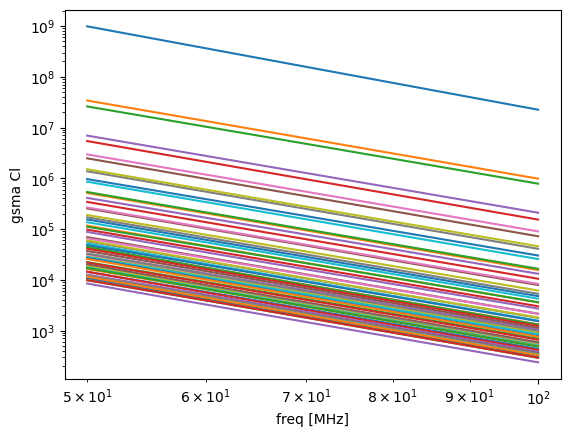

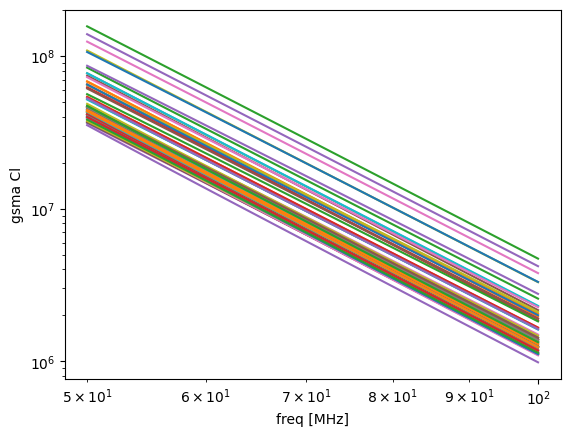

In [5]:
norm = np.array([l*(l+1) for l in range(lmax+1)])
cls_llp1 = np.array(cls) * norm
plt.loglog(nuarr, cls)
plt.xlabel('freq [MHz]')
plt.ylabel('gsma Cl')
plt.show()
plt.loglog(nuarr, cls_llp1)
plt.xlabel('freq [MHz]')
plt.ylabel('gsma Cl')
plt.show()

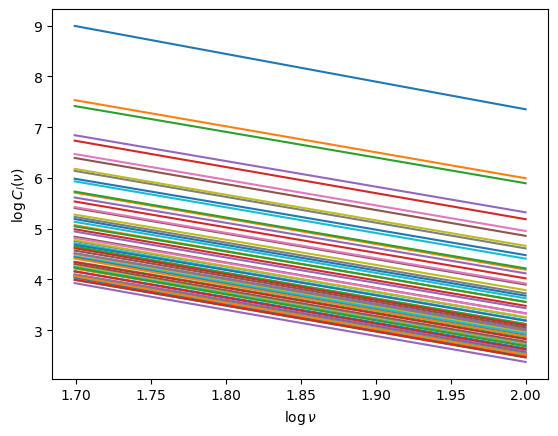

In [6]:
nuarr_log = np.log10(nuarr)
cls_log = np.log10(cls)
plt.plot(nuarr_log, cls_log)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$\log C_l(\nu)$')
plt.show()

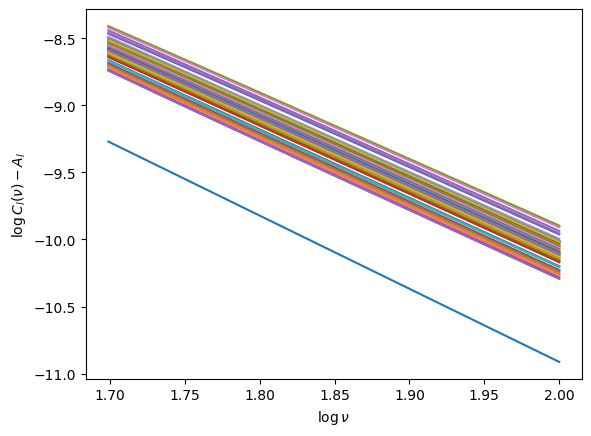

In [7]:
gammas, amplitudes = np.polyfit(nuarr_log, cls_log, deg=1)

cls_log_amplcorr = cls_log-amplitudes

plt.plot(nuarr_log, cls_log_amplcorr)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$\log C_l(\nu) - A_l$')
plt.show()

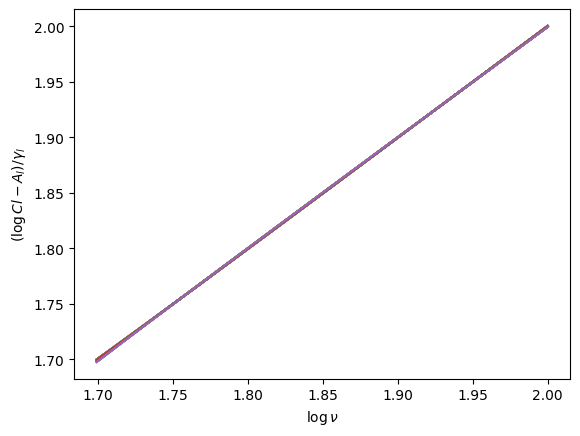

In [8]:
cls_log_corr = cls_log_amplcorr/gammas

plt.plot(nuarr_log, cls_log_corr)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$( \log Cl - A_l ) / \gamma_l$')
plt.show()

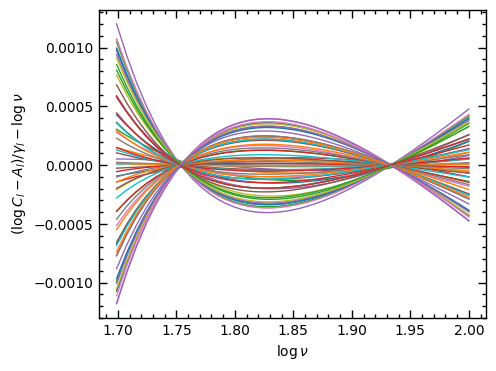

In [9]:
cls_log_corr_flat = cls_log_corr.T-nuarr_log
cls_log_corr_flat = cls_log_corr_flat.T

plt.plot(nuarr_log, cls_log_corr_flat)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$( \log C_l - A_l ) / \gamma_l - \log\nu $')
plt.show()

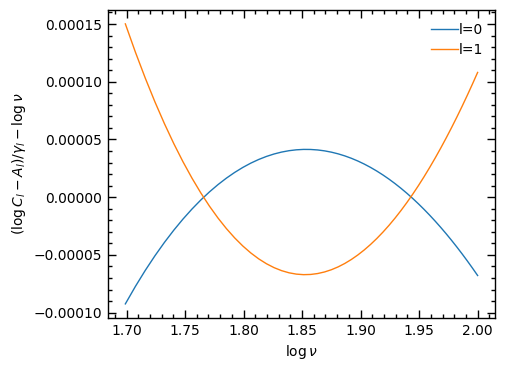

In [10]:
plt.plot(nuarr_log, cls_log_corr_flat[:,:2], label=[f"l={l}" for l in range(2)])
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$( \log C_l - A_l ) / \gamma_l - \log\nu $')
plt.legend()
plt.show()

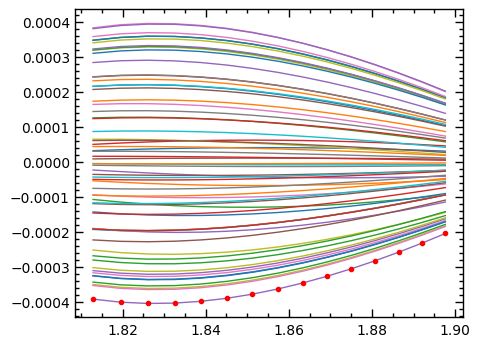

In [11]:
# Identify the smallest-amplitude line of all of them and collapse all other
# lines onto this one.
minval = np.where(cls_log_corr_flat[15:30] == np.min(cls_log_corr_flat[15:30]))
min_l = minval[1][0]
plt.plot(nuarr_log[15:30], cls_log_corr_flat[15:30])
plt.plot(nuarr_log[15:30], cls_log_corr_flat[15:30,min_l], '.', color='r')
plt.show()

In [12]:
fid_line = cls_log_corr_flat[:,min_l]
ds = []
lines = cls_log_corr_flat.T
for line in lines:
    minfunc = lambda d: np.sum((line - d*fid_line)**2)
    if line[0] < 0:
        x0 = -1
    else:
        x0 = 1
    fit = minimize(fun=minfunc, x0=x0, method='Nelder-Mead')
    ds.append(fit.x[0])
ds = np.array(ds)

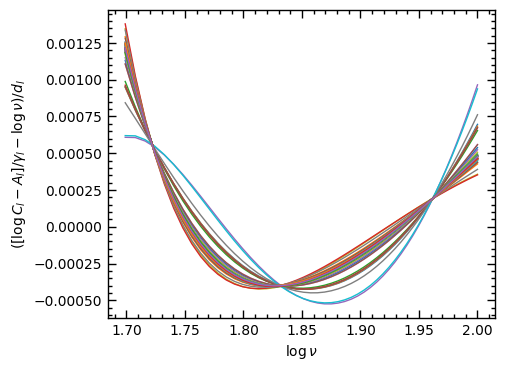

In [13]:
f_estimates = cls_log_corr_flat/ds
plt.plot(nuarr_log, f_estimates)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$([\log C_l - A_l ] / \gamma_l - \log\nu)/d_l $')
plt.show()

In [14]:
np.shape(f_estimates)

(51, 65)

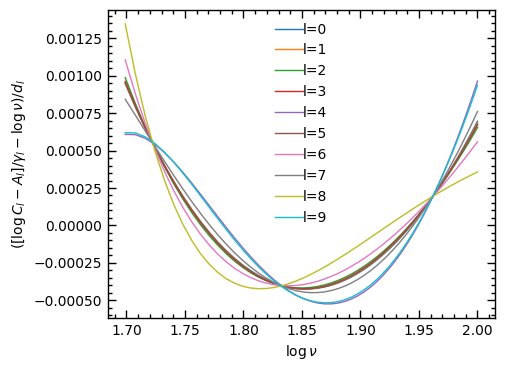

In [15]:
plt.plot(nuarr_log, f_estimates[:,:10], label=[f"l={l}" for l in range(10)])
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$([\log C_l - A_l ] / \gamma_l - \log\nu)/d_l $')
plt.legend()
plt.show()

In [16]:
def pca(arr, N, return_basis=False):
    """
    Represent the rows of an mxn array in an N-dimensional 
    coordinate system, where N < n.

    Returns
    -------
    coordinate matrix
        The rows of the matrix correspond to the coordinates
        of each row of arr in the reduced dimension space.
    basis matrix (if return_basis is True)
        nxN matrix with columns representing the basis vectors of
        the decomposition.
    """
    # Carry out SVD.
    U, S, Vh = svd(arr, full_matrices=False)

    # Truncate the SVD matrices.
    u_matrix = U[:,:N]
    singular_matrix = np.diag(S[:N])

    # Compute the coordinate matrix.
    coordinate_matrix = u_matrix @ singular_matrix
    
    if return_basis:
        basis_matrix = Vh[:N].T
        return coordinate_matrix, basis_matrix
    return coordinate_matrix


In [17]:
np.shape(f_estimates)

(51, 65)

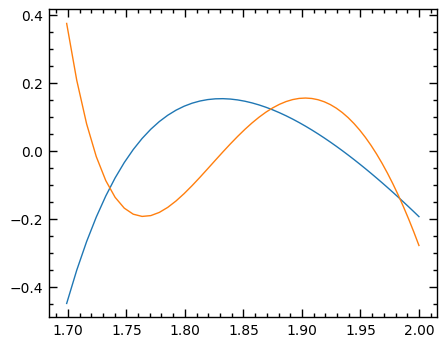

In [18]:
f_estimate_mat = f_estimates.T
coords, basis = pca(f_estimate_mat, N=2, return_basis=True)
plt.plot(nuarr_log, basis)
plt.show()

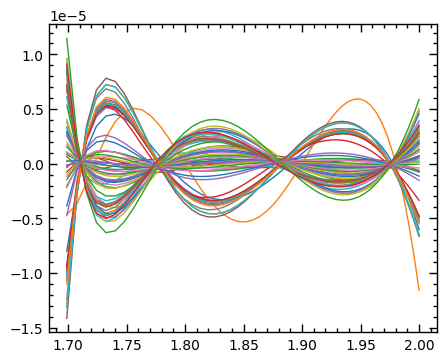

In [19]:
# Reconstruct the l modes using the first N SVD modes.
reconstruct = basis@coords.T
plt.plot(nuarr_log, reconstruct-f_estimates)
plt.show()

There is the question of: does adding a scaling parameter d before carrying out
PCA improve performance over just letting PCA do its thing? It costs us an extra
parameter, so it should be performing better than PCA plus one parameter in the
unscaled case.

In [20]:
np.shape(cls)

(51, 65)

In [21]:
def power_spec_collapse(clarr, nuarr):
    """
    Parameters
    ----------
    clarr : (?, Nfreq) shape array
        An array of power spectrum values to perform the data collapse and train
        the PCA on. Each row corresponds to a different l mode.
    nuarr : (Nfreq,) shape array
        Frequencies in MHz at which the Cl are evaluated.
    """
    nuarr_log = np.log(nuarr)
    cls_log = np.log(clarr)

    gammas, amplitudes = np.polyfit(nuarr_log, cls_log, deg=1)

    cls_log_amplcorr = cls_log-amplitudes

    cls_log_corr = cls_log_amplcorr/gammas

    cls_log_corr_flat = cls_log_corr.T-nuarr_log
    cls_log_corr_flat = cls_log_corr_flat.T

    minval = np.where(cls_log_corr_flat[15:30] == np.min(cls_log_corr_flat[15:30]))
    min_l = minval[1][0]

    fid_line = cls_log_corr_flat[:,min_l]
    ds = []
    lines = cls_log_corr_flat.T
    for line in lines:
        minfunc = lambda d: np.sum((line - d*fid_line)**2)
        if line[0] < 0:
            x0 = -1
        else:
            x0 = 1
        fit = minimize(fun=minfunc, x0=x0, method='Nelder-Mead')
        ds.append(fit.x[0])
    ds = np.array(ds)

    f_estimates = cls_log_corr_flat/ds

    return f_estimates, nuarr_log

    

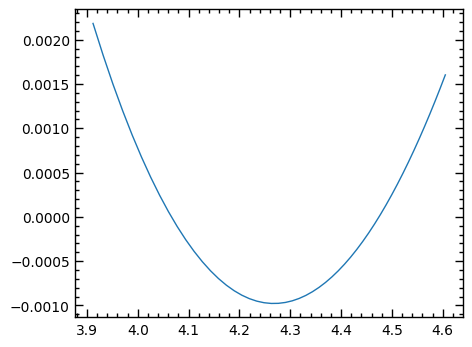

In [22]:
fest, xx = power_spec_collapse(clarr=cls, nuarr=nuarr)
plt.plot(xx, fest[:,0])
plt.show()

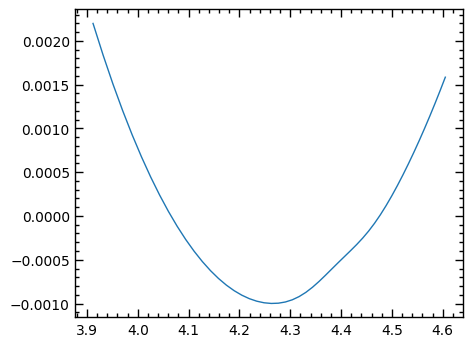

In [23]:
# Inject the 21-cm signal into the C0 mode and run it through the pipeline.
cls_fg21 = np.array(cls)
cls_fg21[:,0] += 1e5*SM.cm21_globalT(nu=nuarr)**2
fest_21, xx = power_spec_collapse(clarr=cls_fg21, nuarr=nuarr)
plt.plot(xx, fest_21[:,0])
plt.show()

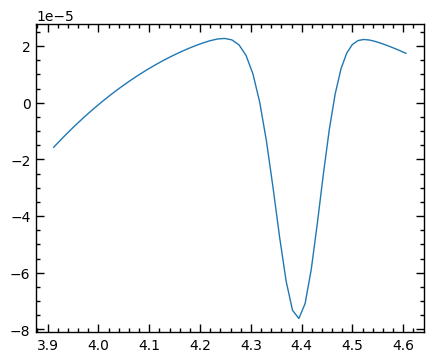

In [24]:
plt.plot(xx, fest[:,0]-fest_21[:,0])
plt.show()

In [25]:
def learn_power_spec_collapse(clarr, nuarr, N=len(nuarr)):
    """
    Parameters
    ----------
    clarr : (?, Nfreq) shape array
        An array of power spectrum values to perform the data collapse and train
        the PCA on. Each row corresponds to a different l mode.
    nuarr : (Nfreq,) shape array
        Frequencies in MHz at which the Cl are evaluated.
    """
    nuarr_log = np.log(nuarr)
    cls_log = np.log(clarr)

    # Fit straight lines to the power laws and collapse onto y=x line.
    gammas, amplitudes = np.polyfit(nuarr_log, cls_log, deg=1)
    cls_log_amplcorr = cls_log-amplitudes
    cls_log_corr = cls_log_amplcorr/gammas

    # Minus the frequency array to collapse onto y=0.
    cls_log_corr_flat = cls_log_corr.T-nuarr_log

    coords, basis = pca(arr=cls_log_corr_flat, N=N, return_basis=True)

    return nuarr_log, coords, basis, cls_log_corr_flat.T


In [26]:
def fit_power_spec_collapse(clarr, nuarr, basis_vecs=None, N=len(nuarr)):
    """
    Parameters
    ----------
    clarr : (?, Nfreq) shape array
        An array of power spectrum values to perform the data collapse and train
        the PCA on. Each row corresponds to a different l mode.
    nuarr : (Nfreq,) shape array
        Frequencies in MHz at which the Cl are evaluated.
    """
    nuarr_log = np.log(nuarr)
    cls_log = np.log(clarr)

    # Fit straight lines to the power laws and collapse onto y=x line.
    gammas, amplitudes = np.polyfit(nuarr_log, cls_log, deg=1)
    cls_log_amplcorr = cls_log-amplitudes
    cls_log_corr = cls_log_amplcorr/gammas

    # Minus the frequency array to collapse onto y=0.
    cls_log_corr_flat = cls_log_corr-nuarr_log
    print(np.shape(cls_log_corr), np.shape(nuarr_log))

    # Use the PCA basis to fit the residual function.
    minfunc = lambda c: np.sum((basis_vecs @ c - cls_log_corr_flat)**2)
    res = minimize(fun=minfunc, x0=[1e-4]*N, method="Nelder-Mead", tol=1e-10)
    if not res.success:
        raise Exception("regression did not terminate successfully.")
    
    return res.x, cls_log_corr_flat

In [27]:
np.shape(basis)

(51, 2)

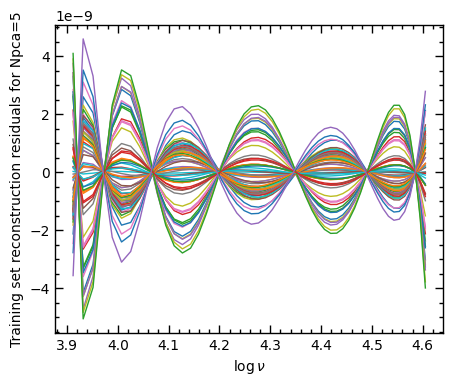

(51,) (51,)


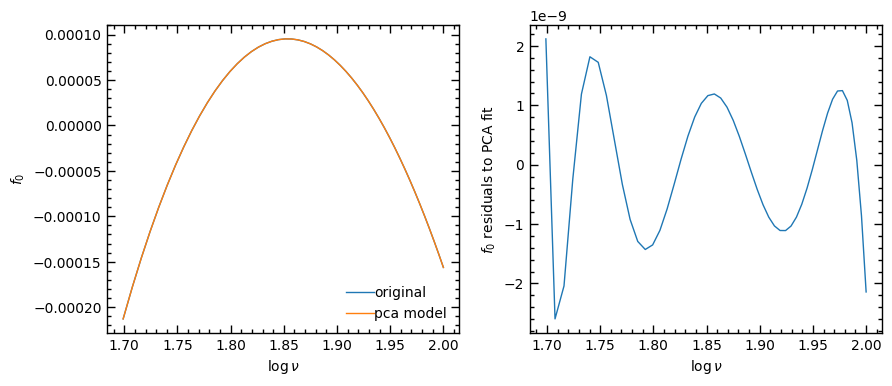

In [28]:
Npca = 5
nulog, coords, basis, funcs_l = learn_power_spec_collapse(clarr=cls, nuarr=nuarr, N=Npca)
reconstruct = basis@coords.T
plt.plot(nulog, reconstruct-funcs_l)
plt.ylabel(f"Training set reconstruction residuals for Npca={Npca}")
plt.xlabel(r'$\log \nu$')
plt.show()

pca_params, func_l = fit_power_spec_collapse(clarr=np.array(cls)[:,0], basis_vecs=basis, nuarr=nuarr, N=Npca)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
residuals1 = func_l-basis@pca_params
ax[0].plot(nuarr_log, func_l, label='original')
ax[0].plot(nuarr_log, basis@pca_params, label='pca model')
ax[1].plot(nuarr_log, func_l-basis@pca_params)
ax[0].set_ylabel(r"$f_{0}$")
ax[1].set_ylabel(r"$f_{0}$ residuals to PCA fit")
ax[0].legend()
ax[0].set_xlabel(r'$\log \nu$')
ax[1].set_xlabel(r'$\log \nu$')
plt.show()

(51,) (51,)


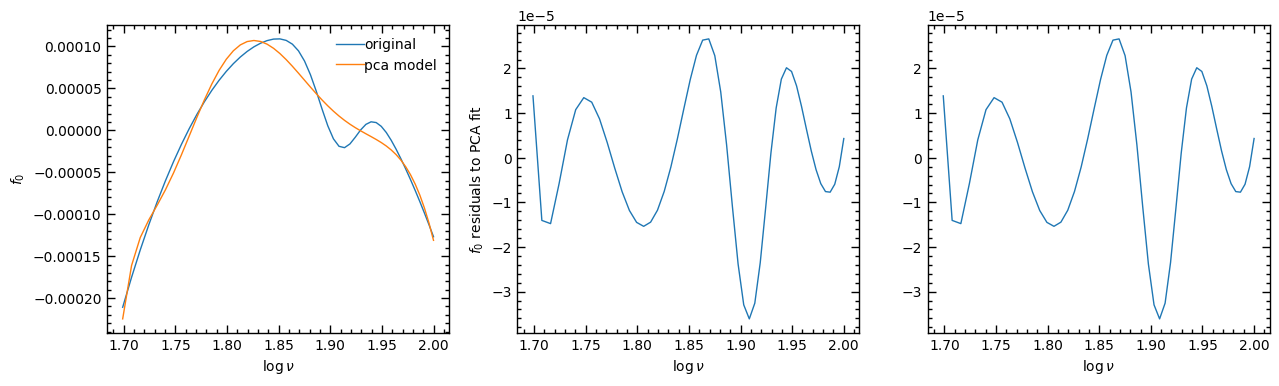

In [29]:
# Inject the 21-cm signal into the C0 mode and run it through the pipeline.
cls_fg21 = np.array(cls)
cls_fg21[:,0] += 1e6*SM.cm21_globalT(nu=nuarr)**2
pca_params, func_l = fit_power_spec_collapse(clarr=cls_fg21[:,0], nuarr=nuarr, basis_vecs=basis, N=Npca)
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(nuarr_log, func_l, label='original')
ax[0].plot(nuarr_log, basis@pca_params, label='pca model')
ax[1].plot(nuarr_log, func_l-basis@pca_params)
ax[2].plot(nuarr_log, func_l-basis@pca_params-residuals1)
ax[0].set_ylabel(r"$f_{0}$")
ax[1].set_ylabel(r"$f_{0}$ residuals to PCA fit")
ax[0].legend()
ax[0].set_xlabel(r'$\log \nu$')
ax[1].set_xlabel(r'$\log \nu$')
ax[0].set_xlabel(r'$\log \nu$')
ax[1].set_xlabel(r'$\log \nu$')
ax[2].set_xlabel(r'$\log \nu$')
plt.show()

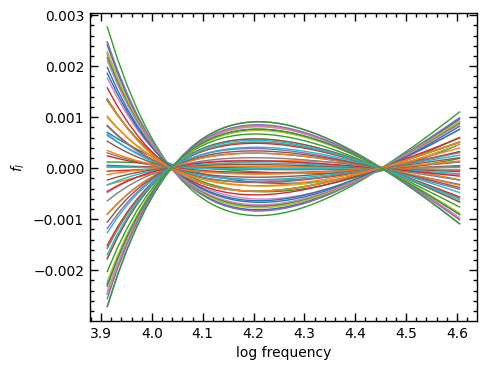

In [30]:
import src.powerlaw_regression as PR
from importlib import reload
reload(PR)
cl_mat = np.array(cls).T
lognu, resid, _ = PR.power_law_residuals(nuarr, cl_mat[2:])
plt.plot(lognu, resid.T)
plt.xlabel("log frequency")
plt.ylabel('$f_l$')
plt.show()

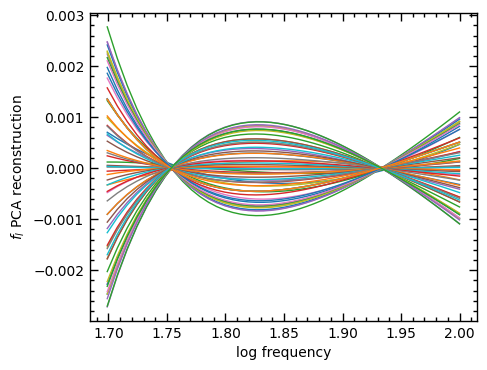

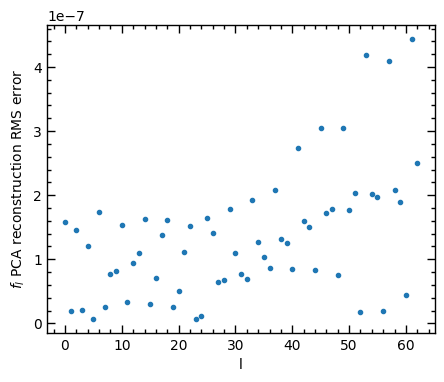

In [31]:
Npca = 3

coord_mat, basis_mat = PR.pca(resid, N=Npca)
reconstruction_rms = np.std(coord_mat@basis_mat-resid, axis=1)
plt.plot(nuarr_log, (coord_mat@basis_mat).T)
plt.xlabel("log frequency")
plt.ylabel('$f_l$ PCA reconstruction')
plt.show()
plt.plot(reconstruction_rms, '.')
plt.xlabel("l")
plt.ylabel("$f_l$ PCA reconstruction RMS error")
plt.show()

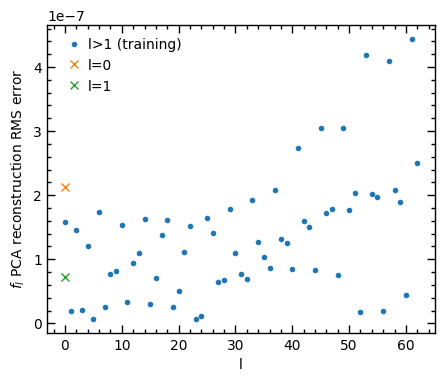

In [32]:
nulog, f0, fit_info0 = PR.power_law_residuals(x=nuarr, y=cl_mat[0])
nulog, f1, fit_info1 = PR.power_law_residuals(x=nuarr, y=cl_mat[1])
p0 = PR.noisefree_linear_regression(y=f0, mat_X=basis_mat.T)
p1 = PR.noisefree_linear_regression(y=f1, mat_X=basis_mat.T)

f0_reconstruction_rms = np.std(p0 @ basis_mat - f0)
f1_reconstruction_rms = np.std(p1 @ basis_mat - f1)
plt.plot(reconstruction_rms, '.', label="l>1 (training)")
plt.plot(f0_reconstruction_rms, 'x', label="l=0")
plt.plot(f1_reconstruction_rms, 'x', label="l=1")
plt.legend()
plt.xlabel("l")
plt.ylabel("$f_l$ PCA reconstruction RMS error")
plt.show()

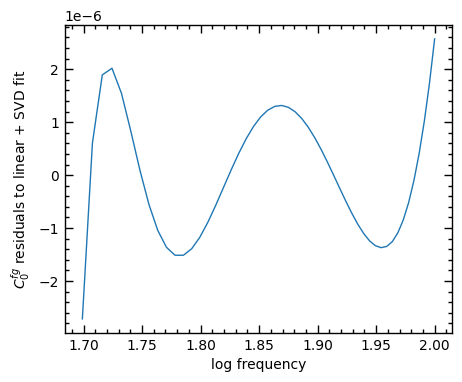

In [33]:
# Regress the linear + SVD model on the original Cl(nu) data.
theta0 = PR.lin_pca_regression(x=nuarr_log, y=np.log(cl_mat[0]), mat_X=basis_mat.T)

# And look at the reconstruction.
c0_reconstruction = PR.lin_pca_forward_mod(x=nuarr_log, mat_X=basis_mat.T) @ theta0
plt.plot(nuarr_log, np.log(cl_mat[0])-c0_reconstruction)
plt.xlabel("log frequency")
plt.ylabel("$C_0^{fg}$ residuals to linear + SVD fit")
plt.show()

Algo:

1. power law residuals on C1 - C32.

2. SVD the resulting functions to find a basis

3. power law residuals on C0

4. SVD + gaussian regression on C0 residuals

We would have to take into account the power law residual fits for the last step,
and how they affect the shape of the Gaussian signal.

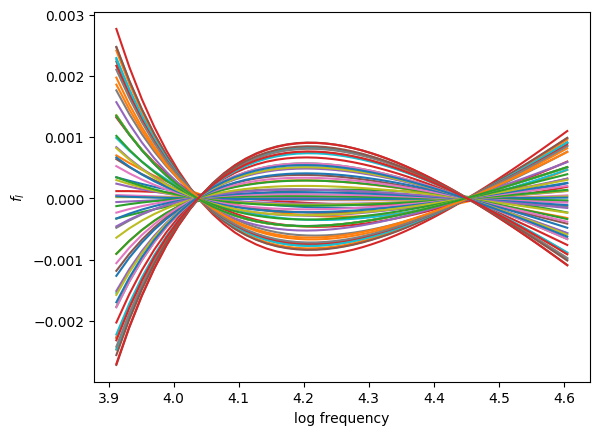

In [9]:
import src.powerlaw_regression as PR
from importlib import reload
reload(PR)
cl_mat = np.array(cls).T
lognu, resid, fitpars = PR.power_law_residuals(nuarr, cl_mat[1:])
plt.plot(lognu, resid.T)
plt.xlabel("log frequency")
plt.ylabel('$f_l$')
plt.show()

In [8]:
np.shape(cl_mat)

(65, 51)

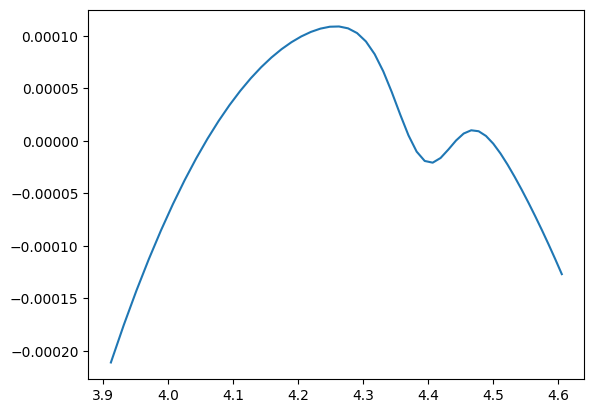

In [10]:
# SVD the functions to find a basis
Npca = 2
coord_mat, basis_mat = PR.pca(resid, N=Npca)

# find power law residuals of C0 with huge 21-cm signal injected
c0_fg21 = np.array(cl_mat[0]) + 1e6*SM.cm21_globalT(nu=nuarr)**2
lognu, resid_c0, fitpars_c0 = PR.power_law_residuals(nuarr, c0_fg21)
plt.plot(lognu, resid_c0)

In [11]:
np.shape(basis_mat)

(2, 51)

In [42]:
np.shape(fitpars)

(64, 2)

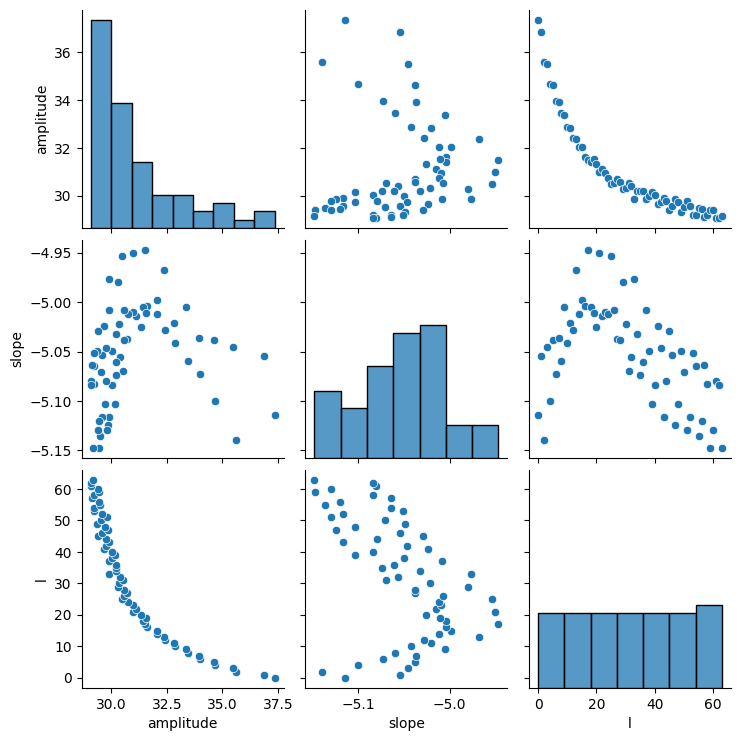

In [43]:
import seaborn as sns
import pandas as pd
fitpars_frame = pd.DataFrame(fitpars, columns=["amplitude","slope"])
fitpars_frame['l'] = np.array(list(range(64)))

sns.pairplot(data=fitpars_frame)

In [44]:
np.shape(coord_mat)

(64, 2)

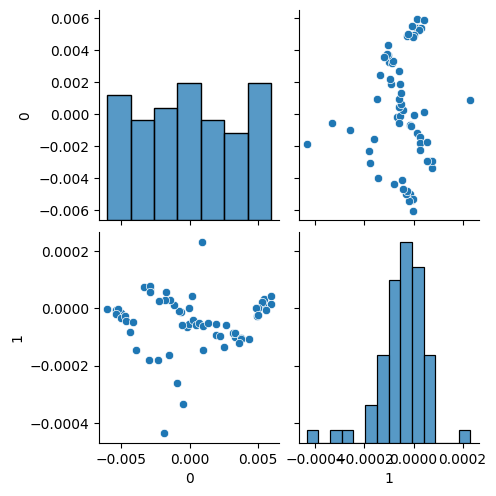

In [45]:
pca_pars_frame = pd.DataFrame(coord_mat)
sns.pairplot(data=pca_pars_frame)


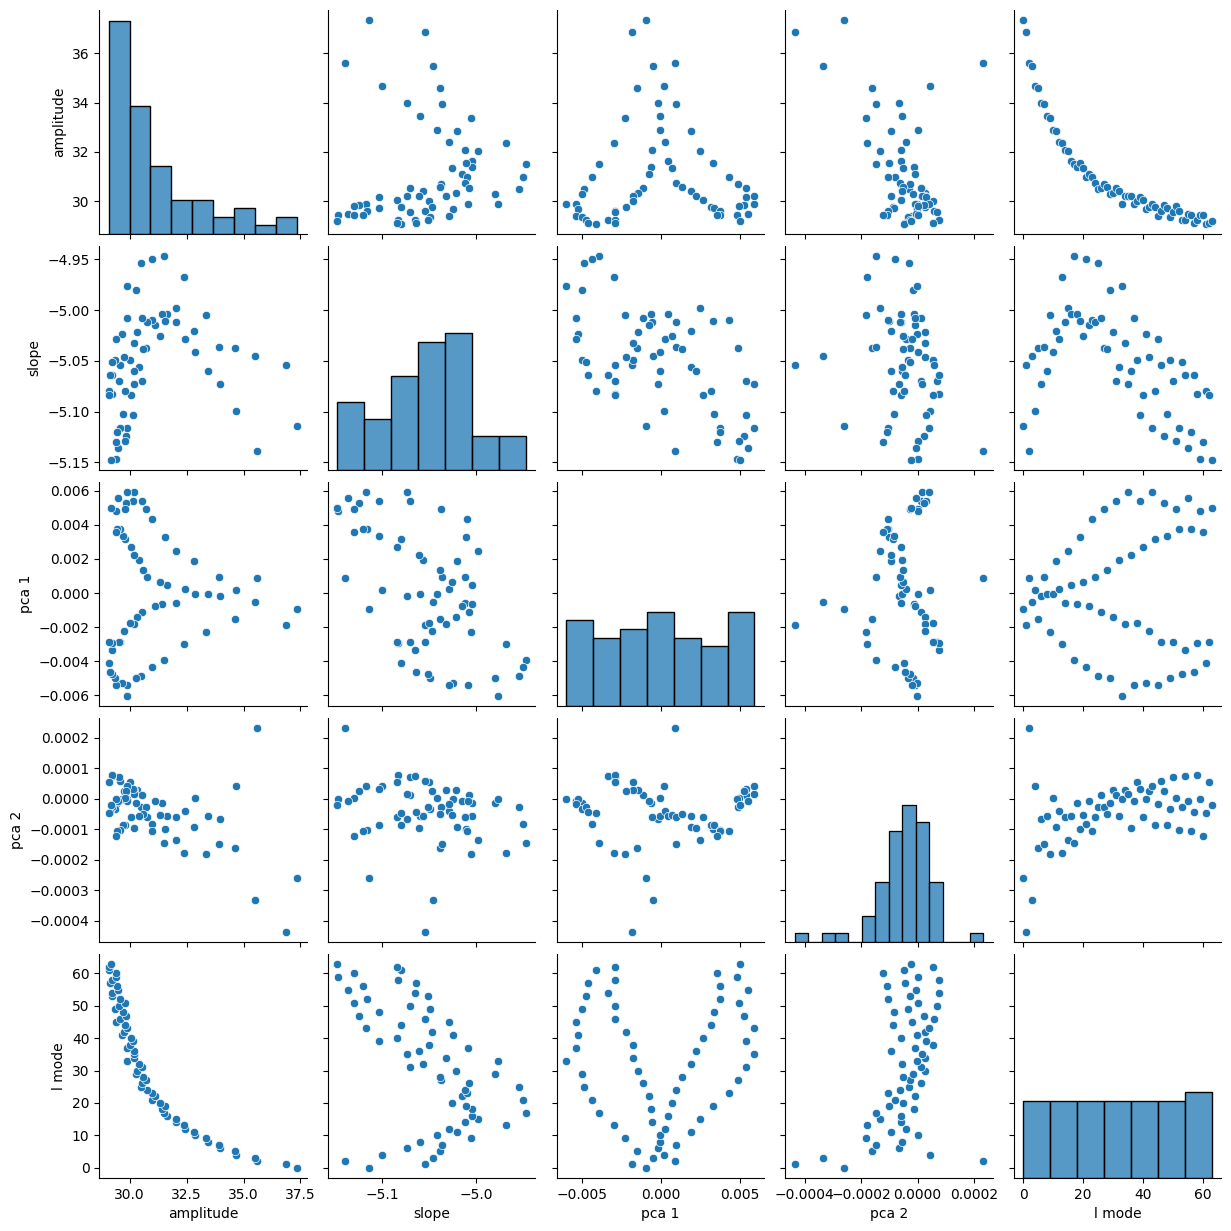

In [46]:
allpars_array = np.append(fitpars, coord_mat, axis=1)
allpars_frame = pd.DataFrame(allpars_array, columns=["amplitude", "slope", "pca 1", "pca 2"])
allpars_frame["l mode"] = list(range(64))
sns.pairplot(data=allpars_frame)

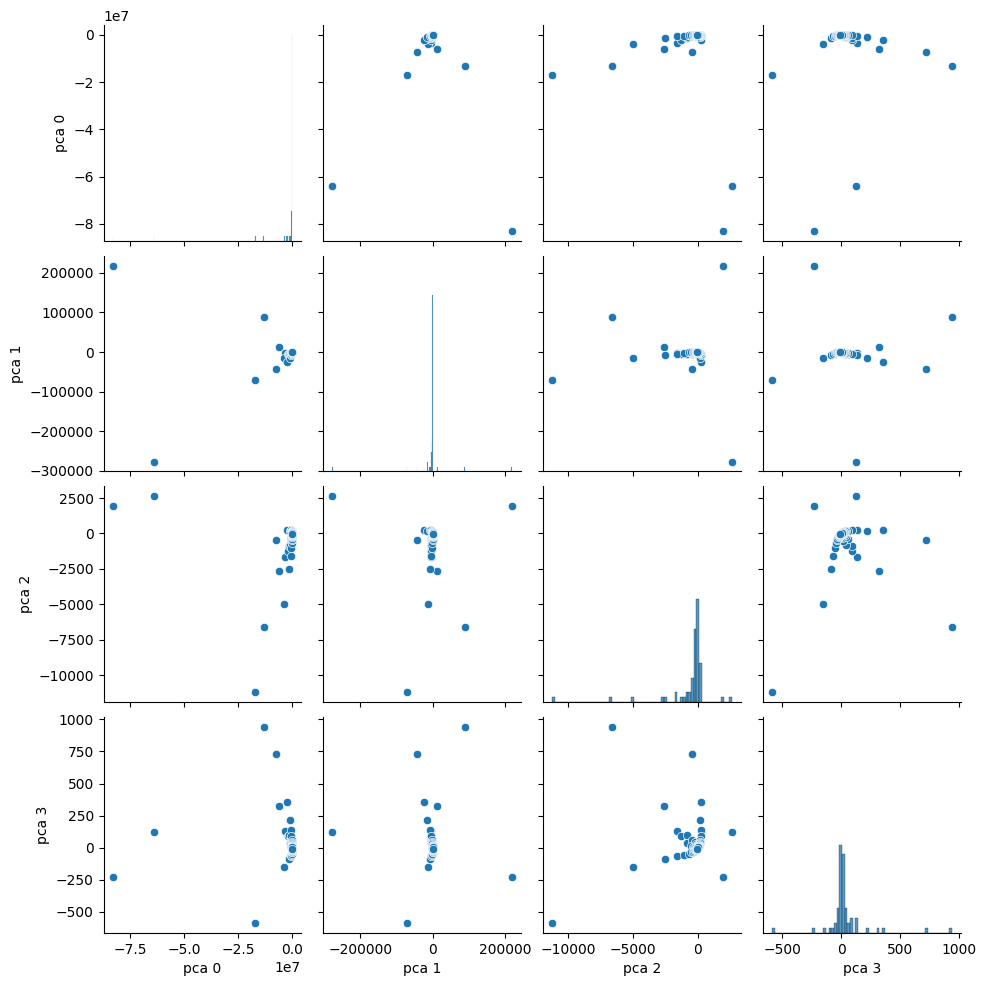

In [39]:
Npca = 4
coord_mat, basis_mat = PR.pca(cl_mat[1:], N=Npca)
pca_coords_frame = pd.DataFrame(coord_mat, columns=[f"pca {n}" for n in range(Npca)])
sns.pairplot(data=pca_coords_frame)

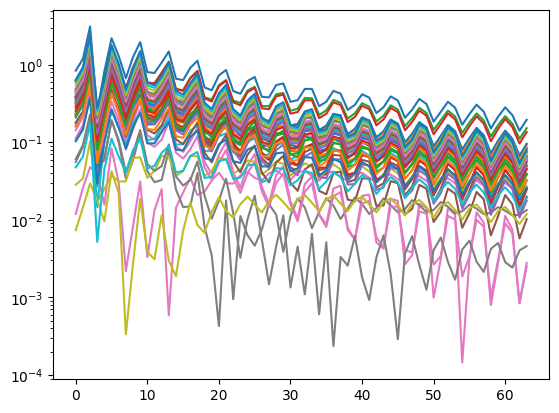

In [40]:
_=plt.semilogy(np.abs(coord_mat@basis_mat-cl_mat[1:]))

In [112]:
# fit the power law + 21-cm signal residuals
res = PR.fg21_residual_regression(nuarr, resid_c0, basis_mat.T, fitpars_c0, x0=[1e-4,1e-4,-0.2*1e3, 80.0,5.0])
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 2.4868124563815313e-08
             x: [ 5.252e-04  1.000e-06 -4.247e+03  1.000e+02  2.413e+00]
           nit: 618
          nfev: 1000
 final_simplex: (array([[ 5.252e-04,  1.000e-06, ...,  1.000e+02,
                         2.413e+00],
                       [ 5.251e-04,  1.000e-06, ...,  1.000e+02,
                         2.416e+00],
                       ...,
                       [ 5.254e-04,  1.000e-06, ...,  1.000e+02,
                         2.388e+00],
                       [ 5.252e-04,  1.000e-06, ...,  1.000e+02,
                         2.382e+00]]), array([ 2.487e-08,  2.487e-08,  2.487e-08,  2.487e-08,
                        2.487e-08,  2.487e-08]))

In [113]:
res.x

array([ 5.25205373e-04,  1.00000000e-06, -4.24652431e+03,  1.00000000e+02,
        2.41313079e+00])

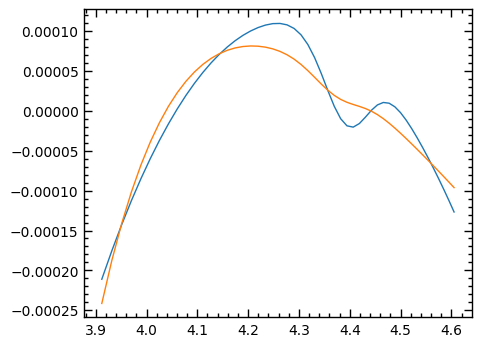

In [121]:
cm21_fid = [-0.2, 80.0, 5.0]
[5.38670592e-04, 4.25269873e-05, 6.00922574e-05, -0.4*1e4, 80.0, 5.0]
plt.plot(lognu, resid_c0)
plt.plot(lognu, PR.fg21_residual_forward_model(nuarr, basis_mat.T, fitpars_c0, [5.25205373e-04,  1.00000000e-06, -.2*1e4,  80, 5e+00]))

In [73]:
cm21

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [74]:
theta_21 = [6.80465866e+10, 7.21211297e+02, 12]
np.exp(-((nuarr-theta_21[1])/theta_21[2])**2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
cl